The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# 稠密连接网络（DenseNet）

ResNet极大地改变了如何参数化深层网络中函数的观点。
*稠密连接网络*（DenseNet） :cite:`Huang.Liu.Van-Der-Maaten.ea.2017`在某种程度上是ResNet的逻辑扩展。让我们先从数学上了解一下。

## 从ResNet到DenseNet

回想一下任意函数的泰勒展开式（Taylor expansion），它把这个函数分解成越来越高阶的项。在$x$接近0时，

$$f(x) = f(0) + f'(0) x + \frac{f''(0)}{2!}  x^2 + \frac{f'''(0)}{3!}  x^3 + \ldots.$$

同样，ResNet将函数展开为

$$f(\mathbf{x}) = \mathbf{x} + g(\mathbf{x}).$$

也就是说，ResNet将$f$分解为两部分：一个简单的线性项和一个复杂的非线性项。
那么再向前拓展一步，如果我们想将$f$拓展成超过两部分的信息呢？
一种方案便是DenseNet。

![ResNet（左）与 DenseNet（右）在跨层连接上的主要区别：使用相加和使用连结。](../img/densenet-block.svg)
:label:`fig_densenet_block`

如 :numref:`fig_densenet_block`所示，ResNet和DenseNet的关键区别在于，DenseNet输出是*连接*（用图中的$[,]$表示）而不是如ResNet的简单相加。
因此，在应用越来越复杂的函数序列后，我们执行从$\mathbf{x}$到其展开式的映射：

$$\mathbf{x} \to \left[
\mathbf{x},
f_1(\mathbf{x}),
f_2([\mathbf{x}, f_1(\mathbf{x})]), f_3([\mathbf{x}, f_1(\mathbf{x}), f_2([\mathbf{x}, f_1(\mathbf{x})])]), \ldots\right].$$

最后，将这些展开式结合到多层感知机中，再次减少特征的数量。
实现起来非常简单：我们不需要添加术语，而是将它们连接起来。
DenseNet这个名字由变量之间的“稠密连接”而得来，最后一层与之前的所有层紧密相连。
稠密连接如 :numref:`fig_densenet`所示。

![稠密连接。](http://d2l.ai/_images/densenet.svg)
:label:`fig_densenet`

稠密网络主要由2部分构成：*稠密块*（dense block）和*过渡层*（transition layer）。
前者定义如何连接输入和输出，而后者则控制通道数量，使其不会太复杂。

## (**稠密块体**)

DenseNet使用了ResNet改良版的“批量规范化、激活和卷积”架构（参见 :numref:`sec_resnet`中的练习）。
我们首先实现一下这个架构。


In [1]:
import tensorflow as tf
from d2l import tensorflow as d2l


class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels):
        super(ConvBlock, self).__init__()
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.conv = tf.keras.layers.Conv2D(
            filters=num_channels, kernel_size=(3, 3), padding='same')

        self.listLayers = [self.bn, self.relu, self.conv]

    def call(self, x):
        y = x
        for layer in self.listLayers.layers:
            y = layer(y)
        y = tf.keras.layers.concatenate([x,y], axis=-1)
        return y

一个*稠密块*由多个卷积块组成，每个卷积块使用相同数量的输出通道。
然而，在前向传播中，我们将每个卷积块的输入和输出在通道维上连结。


In [2]:
class DenseBlock(tf.keras.layers.Layer):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        self.listLayers = []
        for _ in range(num_convs):
            self.listLayers.append(ConvBlock(num_channels))

    def call(self, x):
        for layer in self.listLayers.layers:
            x = layer(x)
        return x

在下面的例子中，我们[**定义一个**]有2个输出通道数为10的(**`DenseBlock`**)。
使用通道数为3的输入时，我们会得到通道数为$3+2\times 10=23$的输出。
卷积块的通道数控制了输出通道数相对于输入通道数的增长，因此也被称为*增长率*（growth rate）。


In [3]:
blk = DenseBlock(2, 10)
X = tf.random.uniform((4, 8, 8, 3))
Y = blk(X)
Y.shape

TensorShape([4, 8, 8, 23])

## [**过渡层**]

由于每个稠密块都会带来通道数的增加，使用过多则会过于复杂化模型。
而过渡层可以用来控制模型复杂度。
它通过$1\times 1$卷积层来减小通道数，并使用步幅为2的平均汇聚层减半高和宽，从而进一步降低模型复杂度。


In [4]:
class TransitionBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, **kwargs):
        super(TransitionBlock, self).__init__(**kwargs)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.conv = tf.keras.layers.Conv2D(num_channels, kernel_size=1)
        self.avg_pool = tf.keras.layers.AvgPool2D(pool_size=2, strides=2)

    def call(self, x):
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.conv(x)
        return self.avg_pool(x)

对上一个例子中稠密块的输出[**使用**]通道数为10的[**过渡层**]。
此时输出的通道数减为10，高和宽均减半。


In [5]:
blk = TransitionBlock(10)
blk(Y).shape

TensorShape([4, 4, 4, 10])

## [**DenseNet模型**]

我们来构造DenseNet模型。DenseNet首先使用同ResNet一样的单卷积层和最大汇聚层。


In [6]:
def block_1():
    return tf.keras.Sequential([
       tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same'),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.ReLU(),
       tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

接下来，类似于ResNet使用的4个残差块，DenseNet使用的是4个稠密块。
与ResNet类似，我们可以设置每个稠密块使用多少个卷积层。
这里我们设成4，从而与 :numref:`sec_resnet`的ResNet-18保持一致。
稠密块里的卷积层通道数（即增长率）设为32，所以每个稠密块将增加128个通道。

在每个模块之间，ResNet通过步幅为2的残差块减小高和宽，DenseNet则使用过渡层来减半高和宽，并减半通道数。


In [7]:
def block_2():
    net = block_1()
    # num_channels为当前的通道数
    num_channels, growth_rate = 64, 32
    num_convs_in_dense_blocks = [4, 4, 4, 4]

    for i, num_convs in enumerate(num_convs_in_dense_blocks):
        net.add(DenseBlock(num_convs, growth_rate))
        # 上一个稠密块的输出通道数
        num_channels += num_convs * growth_rate
        # 在稠密块之间添加一个转换层，使通道数量减半
        if i != len(num_convs_in_dense_blocks) - 1:
            num_channels //= 2
            net.add(TransitionBlock(num_channels))
    return net

与ResNet类似，最后接上全局汇聚层和全连接层来输出结果。


In [8]:
def net():
    net = block_2()
    net.add(tf.keras.layers.BatchNormalization())
    net.add(tf.keras.layers.ReLU())
    net.add(tf.keras.layers.GlobalAvgPool2D())
    net.add(tf.keras.layers.Flatten())
    net.add(tf.keras.layers.Dense(10))
    return net

## [**训练模型**]

由于这里使用了比较深的网络，本节里我们将输入高和宽从224降到96来简化计算。


loss 0.141, train acc 0.950, test acc 0.883
6484.6 examples/sec on /GPU:0


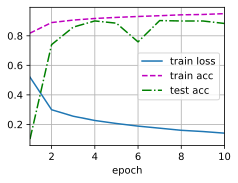

In [9]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 小结

* 在跨层连接上，不同于ResNet中将输入与输出相加，稠密连接网络（DenseNet）在通道维上连结输入与输出。
* DenseNet的主要构建模块是稠密块和过渡层。
* 在构建DenseNet时，我们需要通过添加过渡层来控制网络的维数，从而再次减少通道的数量。

## 练习

1. 为什么我们在过渡层使用平均汇聚层而不是最大汇聚层？
1. DenseNet的优点之一是其模型参数比ResNet小。为什么呢？
1. DenseNet一个诟病的问题是内存或显存消耗过多。
    1. 真的是这样吗？可以把输入形状换成$224 \times 224$，来看看实际的显存消耗。
    1. 有另一种方法来减少显存消耗吗？需要改变框架么？
1. 实现DenseNet论文 :cite:`Huang.Liu.Van-Der-Maaten.ea.2017`表1所示的不同DenseNet版本。
1. 应用DenseNet的思想设计一个基于多层感知机的模型。将其应用于 :numref:`sec_kaggle_house`中的房价预测任务。


[Discussions](https://discuss.d2l.ai/t/1881)
